## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = "resource/non-seasonal/df.csv"
SCALABILITY_FILE = "resource/non-seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/non-seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
train_df = df[:-28]
test_df = df[-28:]
df.head(5)

,date,sales,promo,radio,search,social,tv
0,2019-01-01,784.00000,2003.00000,4779.00000,4603.00000,2123.00000,14120.00000
1,2019-01-02,865.00000,2210.00000,2676.00000,4028.00000,0.00000,7076.00000
2,2019-01-03,803.00000,0.00000,7219.00000,4037.00000,4000.00000,4118.00000
3,2019-01-04,808.00000,0.00000,7826.00000,3722.00000,0.00000,2926.00000
4,2019-01-05,871.00000,1076.00000,7877.00000,4353.00000,1771.00000,10259.00000


In [5]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,promo,3.00000
1,radio,1.25000
2,search,0.80000
3,social,1.30000
4,tv,1.50000


Note that `adstock_df` is optional. If users choose to provide one, make sure the index is named as `regressor`.

In [6]:
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")
adstock_df

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27
regressor,,,,,,,,,,,,,,,,,,,,,
promo,0.08795,0.14952,0.25418,0.25418,0.12709,0.06354,0.03177,0.01589,0.00794,0.00397,...,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
radio,0.00294,0.00529,0.00952,0.01713,0.03084,0.05551,0.09992,0.17985,0.17985,0.12589,...,0.00508,0.00356,0.00249,0.00174,0.00122,0.00085,0.00060,0.00042,0.00029,0.00021
search,0.12903,0.22581,0.22581,0.14678,0.09540,0.06201,0.04031,0.02620,0.01703,0.01107,...,0.00023,0.00015,0.00010,0.00006,0.00004,0.00003,0.00002,0.00001,0.00001,0.00000
social,0.03327,0.04990,0.07486,0.11228,0.16843,0.16843,0.11790,0.08253,0.05777,0.04044,...,0.00163,0.00114,0.00080,0.00056,0.00039,0.00027,0.00019,0.00013,0.00009,0.00007
tv,0.00281,0.00422,0.00632,0.00948,0.01423,0.02134,0.03201,0.04801,0.07202,0.10803,...,0.02944,0.02502,0.02127,0.01808,0.01537,0.01306,0.01110,0.00944,0.00802,0.00682


### Fitting a Basic MMM

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

2023-02-27 20:20:09 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.00245,
}
mmm.set_hyper_params(best_params)

2023-02-27 20:20:09 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-27 20:20:09 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-27 20:20:09 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245


Fit the model with supplied dataframe.

In [9]:
mmm.fit(train_df, num_warmup=1000, num_sample=1000)

2023-02-27 20:20:09 - karpiu-mmm - INFO - Fit final model.
2023-02-27 20:20:09 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-27 20:20:09 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-27 20:20:09 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-27 20:20:09 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

2023-02-27 20:22:00 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.5065923) is within common range (0, 0.8].


### Extracting Insights from the Model

### Attribution

In [10]:
from karpiu.explainability import Attributor

In [11]:
ATTR_START = "2019-03-01"
ATTR_END = "2019-03-01"
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

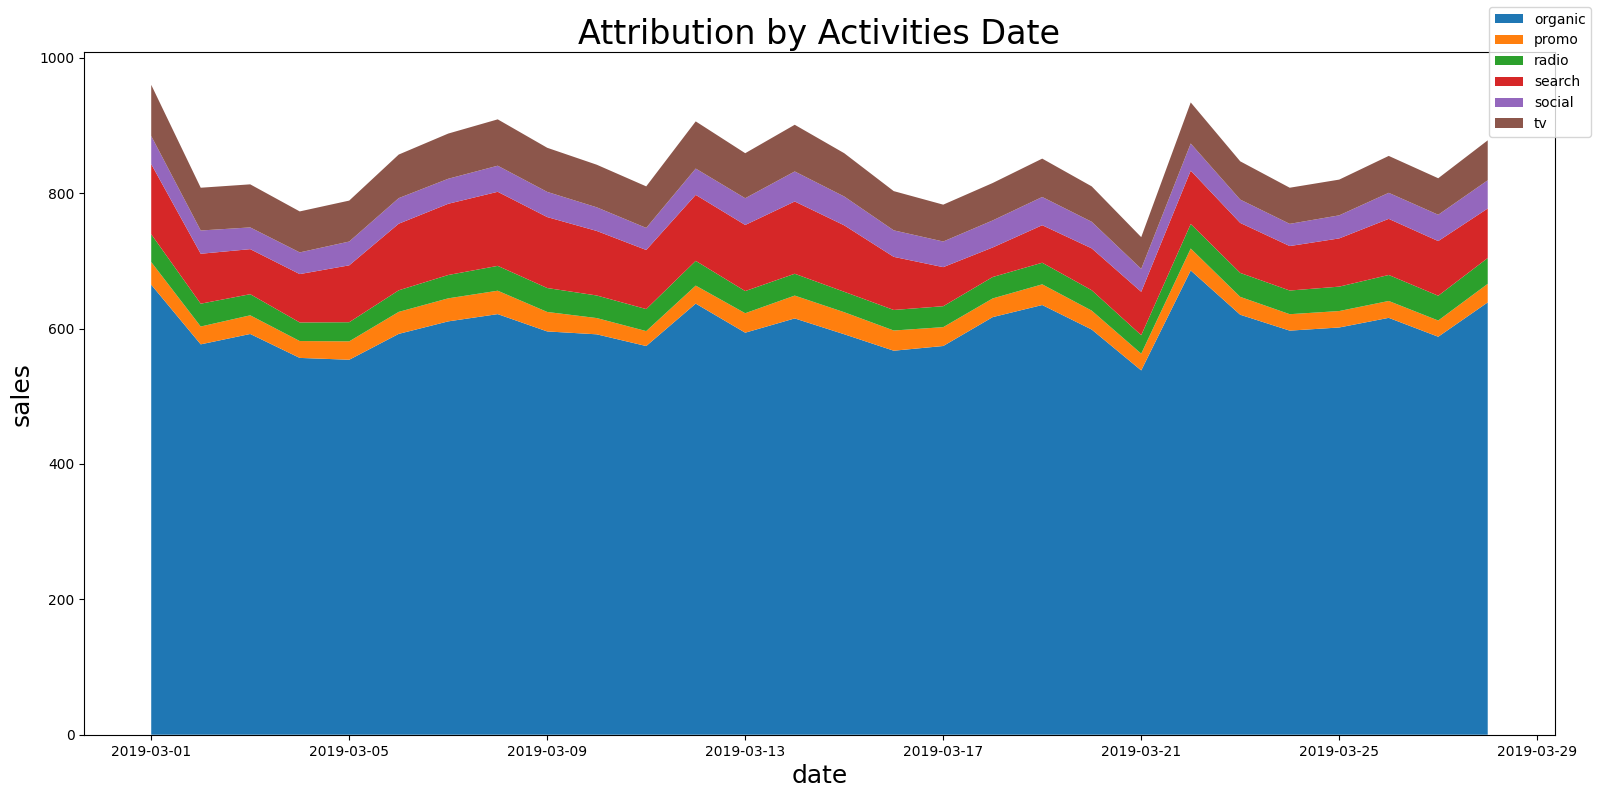

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[["organic"] + paid_channels].values.transpose(),
    labels=["organic"] + paid_channels,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout();

### Cost and Efficiency Analysis

In [13]:
from karpiu.planning import CostCurves

In [14]:
cc = CostCurves(
    model=mmm,
    curve_type="individual",
    n_steps=50,
    channels=paid_channels,
    spend_start=ATTR_START,
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

To prevent overflow, users can provide a scaler in plotting the cost curves.

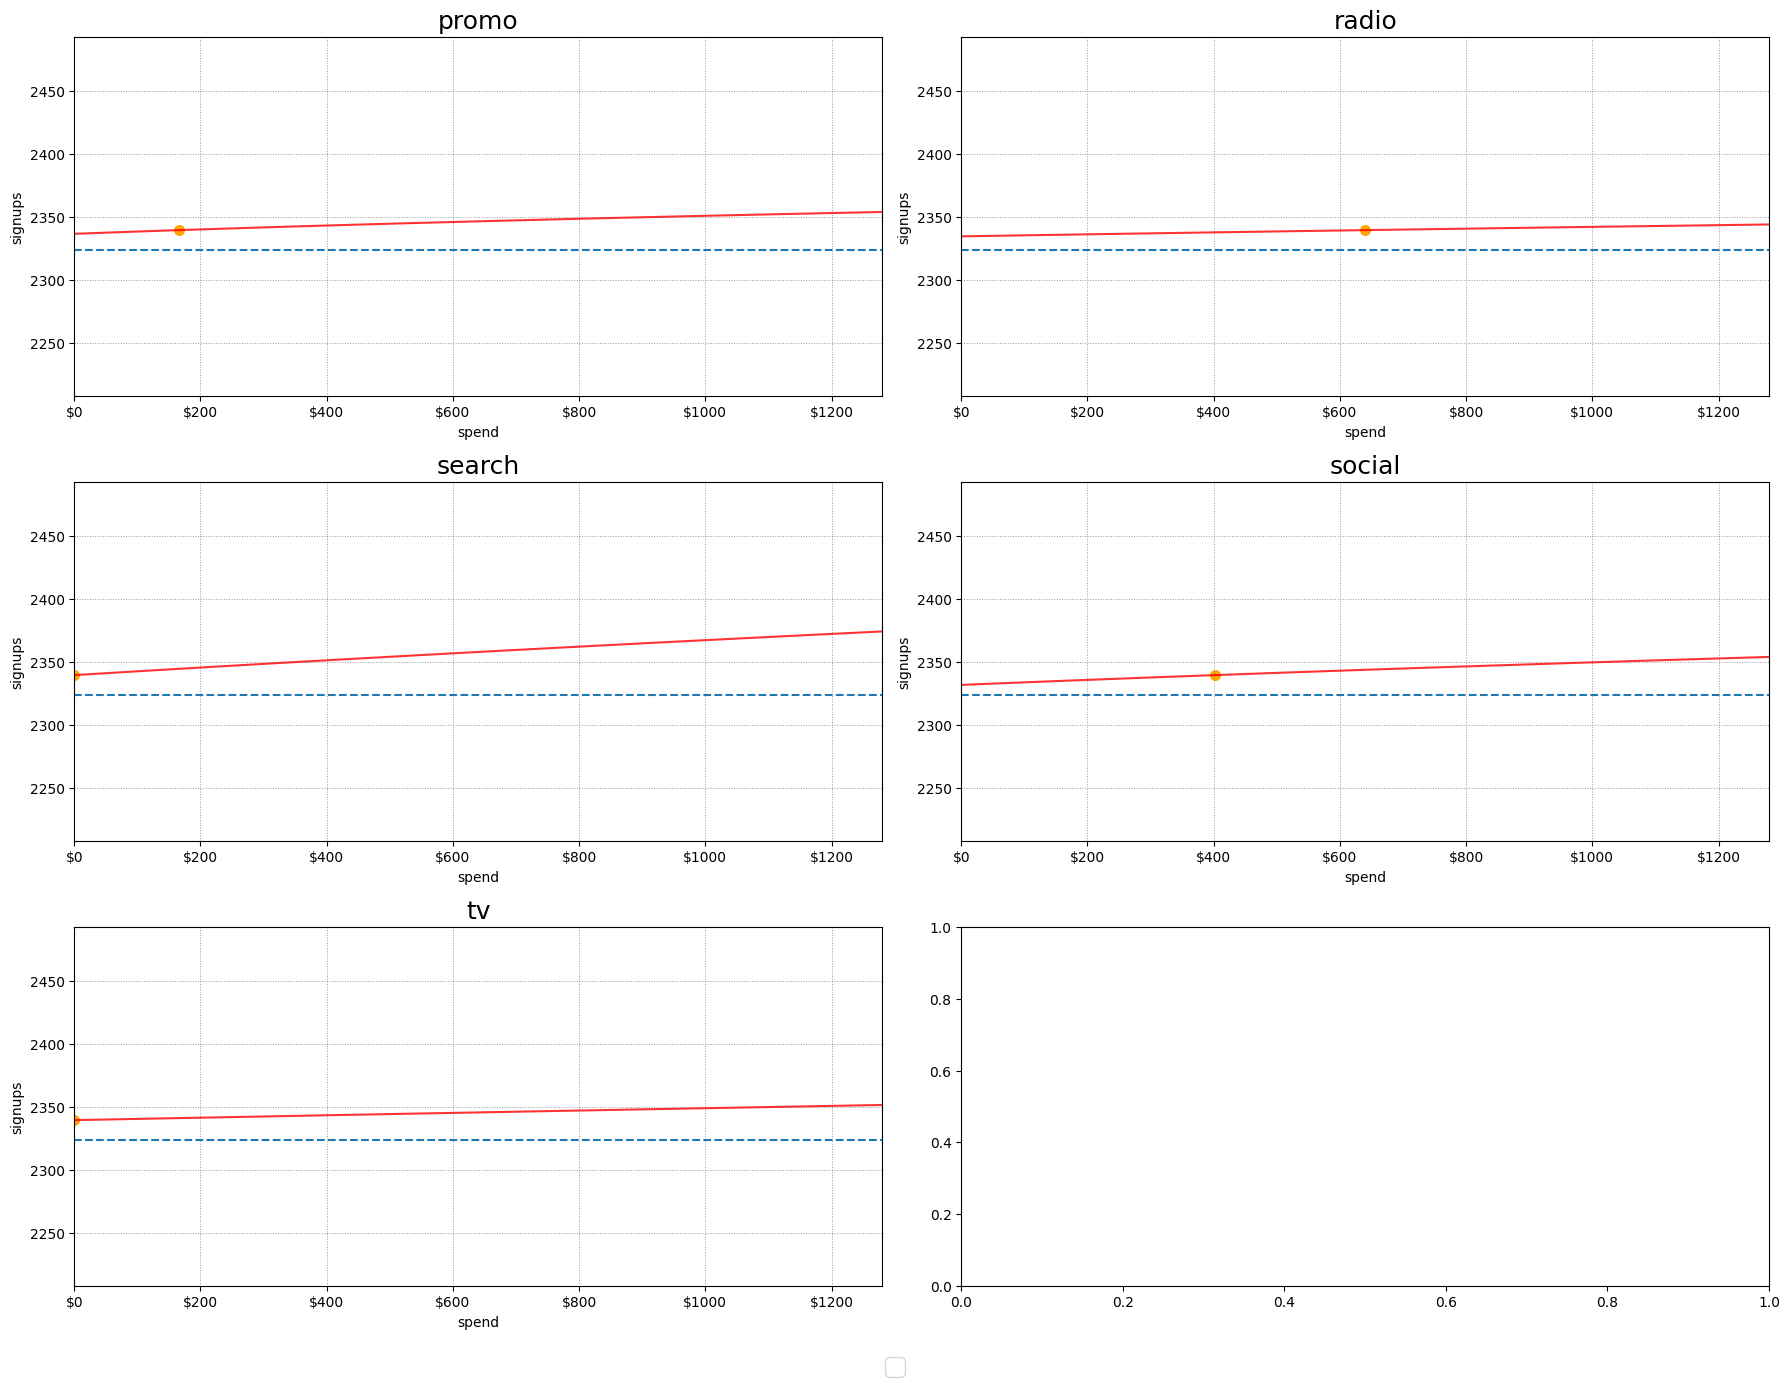

In [15]:
cc.plot(spend_scaler=10, outcome_scaler=10);

### Model Regression Coefficents

In [16]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05736,0.04121,0.07378,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.05506,0.03968,0.06886,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20909,0.18660,0.23081,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.07827,0.05903,0.09767,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.10681,0.08683,0.12805,1.00000,0.00000,0.00000,0.10000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version.

In [17]:
from orbit.diagnostics.plot import plot_predicted_data

In [18]:
pred_df = mmm.predict(df)

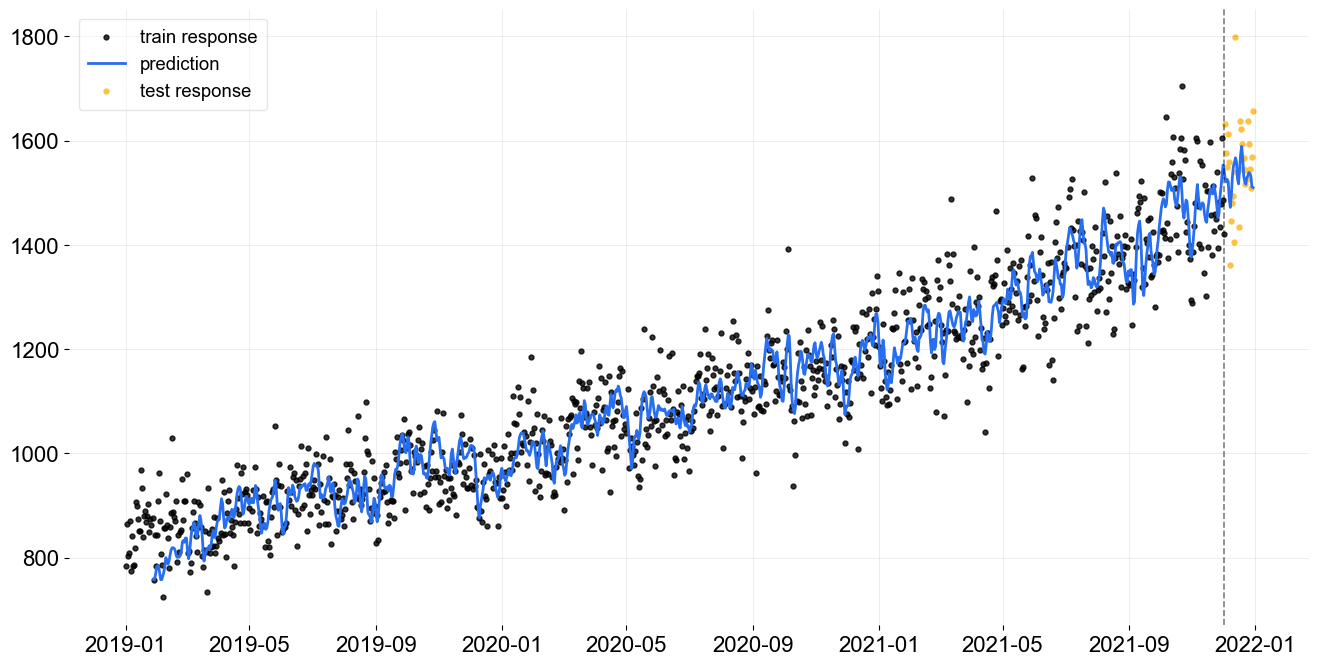

In [19]:
plot_predicted_data(
    training_actual_df=train_df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
    test_actual_df=test_df,
);

Note that this is a non-seasonal model. To model seasonalities and events, check subsequent section.

## Dump Model for Future Usage

In [20]:
import pickle

with open("./resource/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)